In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime, date

In [2]:
import json
import requests

In [3]:
from sodapy import Socrata

In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

# set neat seaborn whitegrid styles for matplotlib charts
plt.style.use('seaborn')
sns.set_style('whitegrid')

#### Pull data using API

In [5]:
MyAppToken = 'qrLSiBH7HoJgfzH80lcJFjaps'

In [6]:
client = Socrata("data.cityofchicago.org",
                 MyAppToken
                )

In order to use only the relevant data for analysis, data for years 2011 and beyond is pulled

In [7]:
# Make a query to get dataset returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
crimes_json = client.get("6zsd-86xi",where="year > 2010",limit=10000000)

In [8]:
# Convert to pandas DataFrame
crimes_df = pd.DataFrame.from_records(crimes_json)

In [9]:
crimes_df.shape

(2087805, 22)

In [10]:
crimes_df.groupby('year').count()['case_number']

year
2011    351678
2012    335833
2013    306873
2014    274900
2015    263588
2016    268322
2017    266114
2018     20496
Name: case_number, dtype: int64

#### Save the intemediate file in order to avoid pulling data again.

In [11]:
crimes_df.to_csv('crimes_df.csv',index=False)

In [74]:
crimes_df = pd.read_csv('crimes_df.csv')

/Users/amit.dingare/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [75]:
crimes_df.columns

Index(['arrest', 'beat', 'block', 'case_number', 'community_area', 'date',
       'description', 'district', 'domestic', 'fbi_code', 'id', 'iucr',
       'latitude', 'location', 'location_description', 'longitude',
       'primary_type', 'updated_on', 'ward', 'x_coordinate', 'y_coordinate',
       'year'],
      dtype='object')

In [76]:
crimes_df['primary_type'].unique()

array(['BATTERY', 'THEFT', 'NARCOTICS', 'ASSAULT', 'CRIMINAL TRESPASS',
       'DECEPTIVE PRACTICE', 'OTHER OFFENSE', 'SEX OFFENSE',
       'CRIMINAL DAMAGE', 'CRIM SEXUAL ASSAULT', 'BURGLARY',
       'MOTOR VEHICLE THEFT', 'ROBBERY', 'WEAPONS VIOLATION',
       'OFFENSE INVOLVING CHILDREN', 'KIDNAPPING',
       'INTERFERENCE WITH PUBLIC OFFICER',
       'CONCEALED CARRY LICENSE VIOLATION', 'HOMICIDE', 'STALKING',
       'PUBLIC PEACE VIOLATION', 'ARSON', 'NON-CRIMINAL',
       'LIQUOR LAW VIOLATION', 'PROSTITUTION', 'INTIMIDATION', 'GAMBLING',
       'HUMAN TRAFFICKING', 'OBSCENITY', 'OTHER NARCOTIC VIOLATION',
       'PUBLIC INDECENCY', 'NON - CRIMINAL',
       'NON-CRIMINAL (SUBJECT SPECIFIED)'], dtype=object)

#### Remove sparse primary crime types.
As you can see there are quite a large number of unique crime types. A lot of these crime types have only a few incidents. Let us remove all these sparse types. This will help in improving the model accuracy later on.

In [77]:
select_crimes = (crimes_df.groupby(['year','primary_type']).count()['case_number']*100/
                             crimes_df.groupby(['year']).count()['case_number']).to_frame().reset_index()
select_crimes.rename(columns={"case_number":"percentage"},inplace=True)
crimestokeep = select_crimes[select_crimes['percentage'] > 5]['primary_type'].unique().tolist()

crimestokeep list has only a selected number of crimes

In [78]:
crimestokeep

['ASSAULT',
 'BATTERY',
 'BURGLARY',
 'CRIMINAL DAMAGE',
 'MOTOR VEHICLE THEFT',
 'NARCOTICS',
 'OTHER OFFENSE',
 'THEFT',
 'DECEPTIVE PRACTICE']

In [79]:
crimes_df.loc[crimes_df['primary_type'].isin(crimestokeep),'crime_cat'] = crimes_df['primary_type']
crimes_df.loc[~crimes_df['primary_type'].isin(crimestokeep),'crime_cat'] = 'MISC'

In [80]:
crimes_df.groupby(['crime_cat']).count()['case_number'].to_frame().reset_index().sort_values('case_number',ascending=False)

,crime_cat,case_number
9,THEFT,471572
1,BATTERY,375141
5,MISC,249931
3,CRIMINAL DAMAGE,222544
7,NARCOTICS,186821
0,ASSAULT,131736
8,OTHER OFFENSE,125792
2,BURGLARY,123323
4,DECEPTIVE PRACTICE,108699
6,MOTOR VEHICLE THEFT,92245


In [81]:
uniquecrimecat = crimes_df['crime_cat'].unique().tolist()
uniquecrimecat

['BATTERY',
 'THEFT',
 'NARCOTICS',
 'ASSAULT',
 'MISC',
 'DECEPTIVE PRACTICE',
 'OTHER OFFENSE',
 'CRIMINAL DAMAGE',
 'BURGLARY',
 'MOTOR VEHICLE THEFT']

#### Create features associated with date and time

In [82]:
crimes_df['datetime'] = pd.to_datetime(crimes_df['date'])

In [83]:
crimes_df['datetime'].head()

0   2014-07-20 03:00:00
1   2013-12-09 09:00:00
2   2014-12-21 15:25:00
3   2016-04-18 22:30:00
4   2015-03-09 16:34:00
Name: datetime, dtype: datetime64[ns]

In [84]:
crimes_df['dt'] = crimes_df['datetime'].astype(str).apply(lambda x:x.split(" ")[0])
crimes_df['time'] = crimes_df['datetime'].astype(str).apply(lambda x:x.split(" ")[1])

In [85]:
crimes_df['dow'] = crimes_df['datetime'].dt.dayofweek

In [86]:
crimes_df['week'] = crimes_df['datetime'].dt.week

In [87]:
crimes_df[crimes_df['dow']>=5].head()

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,...,ward,x_coordinate,y_coordinate,year,crime_cat,datetime,dt,time,dow,week
0,False,1924,035XX N CLARK ST,HX352405,6.0,2014-07-20T03:00:00.000,SIMPLE,19.0,False,08B,...,44.0,NaN,NaN,2014,BATTERY,2014-07-20 03:00:00,2014-07-20,03:00:00,6,29
2,False,2211,109XX S TROY ST,HX550554,74.0,2014-12-21T15:25:00.000,$500 AND UNDER,22.0,False,06,...,19.0,NaN,NaN,2014,THEFT,2014-12-21 15:25:00,2014-12-21,15:25:00,6,51
8,True,1134,033XX W CONGRESS PKWY,HY476300,27.0,2015-10-25T18:54:00.000,MANU/DEL:CANNABIS 10GM OR LESS,11.0,False,18,...,24.0,NaN,NaN,2015,NARCOTICS,2015-10-25 18:54:00,2015-10-25,18:54:00,6,43
12,False,1824,011XX N CLARK ST,HZ252386,8.0,2016-04-03T05:00:00.000,CREDIT CARD FRAUD,18.0,False,11,...,42.0,NaN,NaN,2016,DECEPTIVE PRACTICE,2016-04-03 05:00:00,2016-04-03,05:00:00,6,13
14,False,524,012XX W 119TH ST,HZ254943,53.0,2016-03-19T19:00:00.000,$500 AND UNDER,5.0,False,06,...,34.0,NaN,NaN,2016,THEFT,2016-03-19 19:00:00,2016-03-19,19:00:00,5,11


In [88]:
crimes_df.loc[crimes_df['dow'] >=5,'weekend'] = 1
crimes_df.loc[crimes_df['dow'] < 5,'weekend'] = 0

In [89]:
len(crimes_df['community_area'].unique().tolist())

79

#### Exploratory Data Analysis

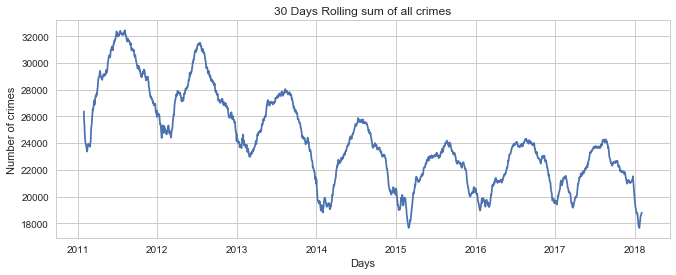

In [90]:
fig = plt.figure(figsize=(11,4))
crimes_df_plot = crimes_df
crimes_df_plot.index = pd.DatetimeIndex(crimes_df_plot.date)
crimes_df_plot.resample('D').size().rolling(30).sum().plot()
plt.title('30 Days Rolling sum of all crimes')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()
fig.savefig('30 Days Rolling sum of all crimes.png')

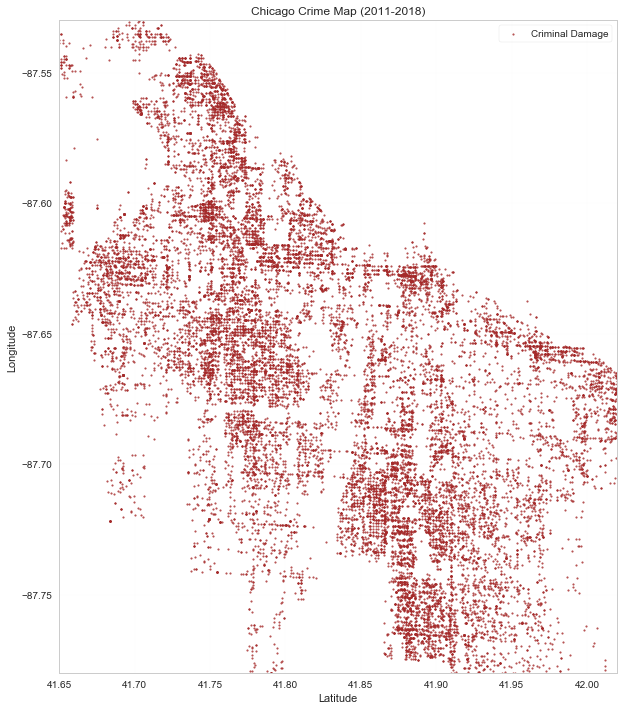

CPU times: user 1.11 s, sys: 103 ms, total: 1.21 s
Wall time: 1.21 s


In [91]:
%%time

# get min/max lat and long
#minLat = crimes['Latitude'].min().compute()
#maxLat = crimes['Latitude'].max().compute()
#minLong = crimes['Longitude'].min().compute()
#maxLong = crimes['Longitude'].max().compute()

# get crime geo data
crime_geo = crimes_df[['crime_cat', 'latitude', 'longitude']].dropna()

# get battery
battery = crime_geo[(crime_geo['crime_cat']=='BATTERY')]

# get narcotics
narcotics = crime_geo[(crime_geo['crime_cat']=='NARCOTICS')]


# get criminal assaults
assaults = crime_geo[(crime_geo['crime_cat']=='ASSAULT')]

# get thefts
thefts = crime_geo[(crime_geo['crime_cat']=='THEFT')]
#print(thefts.shape)

# get misc
misc = crime_geo[(crime_geo['crime_cat']=='MISC')]

# get criminal damage
criminaldamage = crime_geo[(crime_geo['crime_cat']=='CRIMINAL DAMAGE')]


# create scatter map plot
fig,ax= plt.subplots(1, 1, figsize=(10,12))
plt.xlim(41.65, 42.02) # (minLat, maxLat)
plt.ylim(-87.78, -87.53) # (minLong, maxLong)
#ax.set_facecolor('black')

# plot thefts, battery, kidnappings and sexual assaults
# ax.scatter(thefts['latitude'], thefts['longitude'],\
#                             s=1, alpha=0.8, color='#51cc7a', label='Theft') # green
# ax.scatter(misc['latitude'], misc['longitude'],\
#             s=3, alpha=0.8, color='#ff9933', label='Misc Crimes') # orange
# ax.scatter(narcotics['latitude'], narcotics['longitude'],\
#                             s=3, alpha=0.8, color='#3333ff', label='Narcotics') # blue
# ax.scatter(battery['latitude'], battery['longitude'],\
#                             s=3, alpha=0.8, color='#ff0000', label='Battery') # red
# ax.scatter(criminaldamage['latitude'], criminaldamage['longitude'],\
#                             s=3, alpha=0.8, color='#00FFFF', label='Criminal Damage') # cyan
ax.scatter(assaults['latitude'], assaults['longitude'],\
                            s=3, alpha=0.8, color='#A52A2A', label='Criminal Damage') # brown
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Chicago Crime Map (2011-2018)')
plt.legend(loc='upper right', frameon=True)
plt.grid(linestyle = '--', linewidth = 0.05)
plt.show()
fig.savefig('assaults.png')

In [92]:
crimes_df_sum = crimes_df.groupby(['dt','crime_cat']).count()['case_number'].to_frame().reset_index()
#crimes_df_sum.set_index('date',inplace=True)
crimes_df_sum.rename(columns={'case_number':'count'},inplace=True)
crimes_df_sum['dt'] = pd.to_datetime(crimes_df_sum['dt'], format='%Y-%m-%d')

In [102]:
crimes_df_pivot = crimes_df_sum.pivot(index='dt',columns='crime_cat', values='count')

In [103]:
crimes_df_pivot.head()

crime_cat,ASSAULT,BATTERY,BURGLARY,CRIMINAL DAMAGE,DECEPTIVE PRACTICE,MISC,MOTOR VEHICLE THEFT,NARCOTICS,OTHER OFFENSE,THEFT
dt,,,,,,,,,,
2011-01-01,52,285,50,148,115,266,61,92,102,348
2011-01-02,39,136,43,83,13,69,55,90,45,138
2011-01-03,38,139,75,89,25,101,71,123,46,177
2011-01-04,46,143,73,91,25,105,61,99,49,153
2011-01-05,51,129,72,74,32,91,67,121,70,189


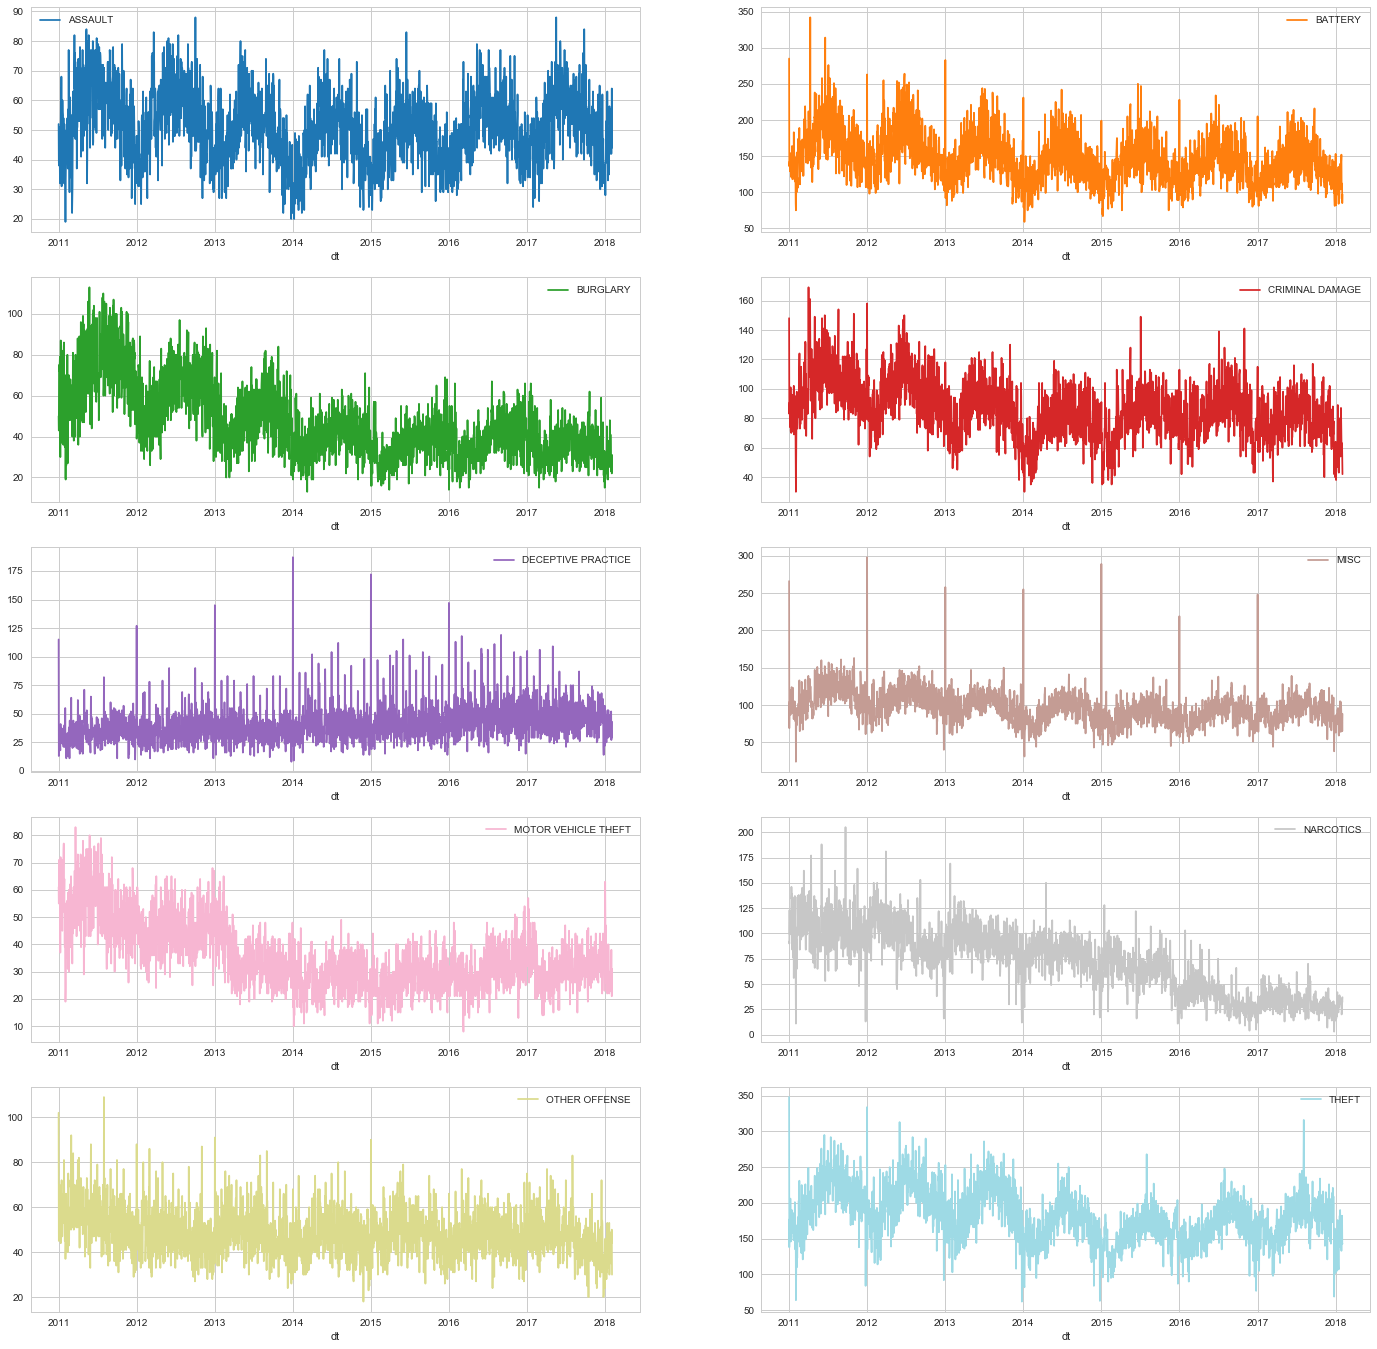

In [112]:
crimes_df_pivot.plot(figsize=(24, 24), subplots=True, layout=(5, 2),\
                     cmap='tab20', sharex=False, sharey=False)
plt.show()

#### Let us make forecast using prophet

In [113]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

#### The first step is to rename the columns to ds and y in order to comply with the prophet API.

In [153]:
from matplotlib.font_manager import FontProperties

def plot(self, fcst, test, ax=None, uncertainty=True, plot_cap=True, xlabel='ds',
         ylabel='y'):
    """Plot the Prophet forecast.
    Parameters
    ----------
    fcst: pd.DataFrame output of self.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    Returns
    -------
    A matplotlib figure.
    """
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=(10, 6))
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds'].dt.to_pydatetime()
    ax.plot(self.history['ds'].dt.to_pydatetime(), self.history['y'], 'k.')
    ax.plot(fcst_t, fcst['yhat'], ls='-', c='#0072B2')
    #print(test.iloc[:,1].head())
    ax.plot(test['dt'],test.iloc[:,1],'ro', markersize=2)
    if 'cap' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k')
    if self.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k')
    if uncertainty:
        ax.fill_between(fcst_t, fcst['yhat_lower'], fcst['yhat_upper'],
                        color='#0072B2', alpha=0.2)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    titletext = 'Actual vs. Forecasted ' + test.columns[1]
    ax.set_title(titletext)
    L=ax.legend(fancybox=True,shadow=True) #get the legend
    L.get_texts()[0].set_text('Training Actual') #change the legend text for 1st plot
    L.get_texts()[1].set_text('Forecasted') #change the legend text for 2nd plot
    L.get_texts()[2].set_text('Holdout Actual') #change the legend text for 3rd plot
    fig.tight_layout()
    fig.savefig(test.columns[1] + ".png")
    return fig

In [154]:
def split_df(df):
    train = df.loc[df['dt']<'2017-01-01',:]
    test = df.loc[(df['dt']>='2017-01-01') 
                                     & (df['dt']<'2018-01-01'),:]
    return (train, test)

In [157]:
def pred_using_prophet(df,i):
    (train, test) = split_df(df)
    train.loc[:,'ds'] = train.loc[:,'dt']
    train.loc[:,'y'] = train.iloc[:,i]
    periods = test.shape[0]
    m1 = Prophet(daily_seasonality=True,weekly_seasonality=True)
    m1.fit(train)
    future1 = m1.make_future_dataframe(periods=periods)
    forecast1 = m1.predict(future1)
    testshort = test.iloc[:,[0,i]]
    print(plot(m1,forecast1,testshort))
    print(m1.plot_components(forecast1))
    merged_df = pd.merge(forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods),test.iloc[:,:i+1],left_on='ds',right_on='dt')
    merged_df['week'] = merged_df['ds'].dt.week
    merged_df.set_index('ds', inplace=True)
    merged_df_sum = merged_df.groupby(['week']).sum()[[merged_df.columns[0],merged_df.columns[-2]]].reset_index()
    #print (merged_df.head())
    #print (merged_df_sum.head())
    rmse = sqrt(mean_squared_error(merged_df.iloc[:,-1], merged_df.iloc[:,0]))
    rmse_week = sqrt(mean_squared_error(merged_df_sum.iloc[:,-1], merged_df_sum.iloc[:,0]))
    return (rmse,rmse_week)

/Users/amit.dingare/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/amit.dingare/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/amit.dingare/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `

Figure(720x432)
Figure(648x864)
Figure(720x432)
Figure(648x864)
Figure(720x432)
Figure(648x864)
Figure(720x432)
Figure(648x864)
Figure(720x432)
Figure(648x864)
Figure(720x432)
Figure(648x864)
Figure(720x432)
Figure(648x864)
Figure(720x432)
Figure(648x864)
Figure(720x432)
Figure(648x864)
Figure(720x432)
Figure(648x864)


,RMSE,RMSE_Week
ASSAULT,31.586542,347.613733
BATTERY,114.799381,924.833582
BURGLARY,17.808974,225.269027
CRIMINAL DAMAGE,63.849625,534.193011
DECEPTIVE PRACTICE,32.601571,321.400182
MISC,64.141454,623.272551
MOTOR VEHICLE THEFT,15.174765,195.934693
NARCOTICS,30.956825,199.562743
OTHER OFFENSE,26.766577,304.631366
THEFT,153.880238,1214.010209


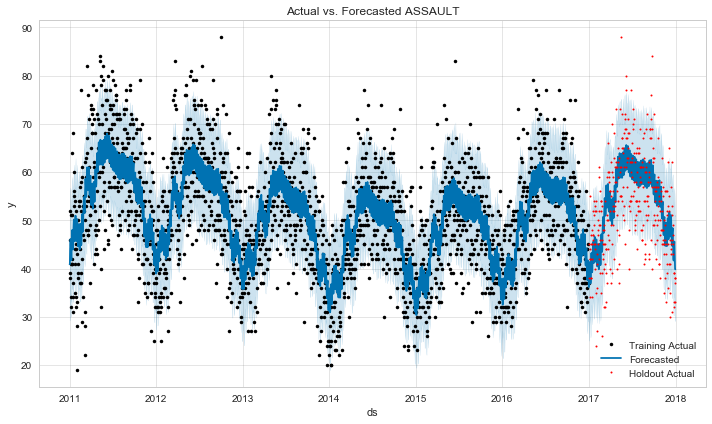

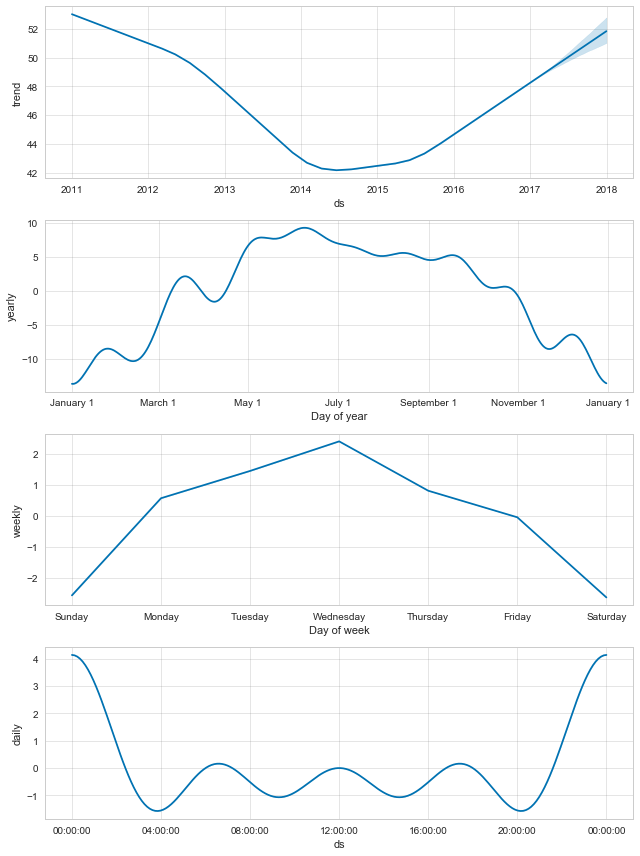

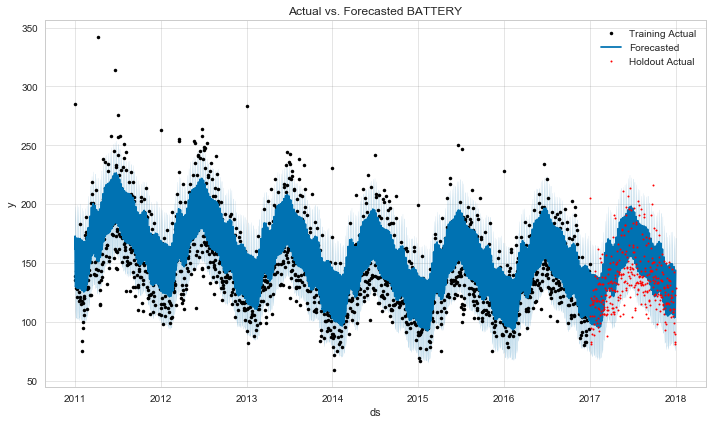

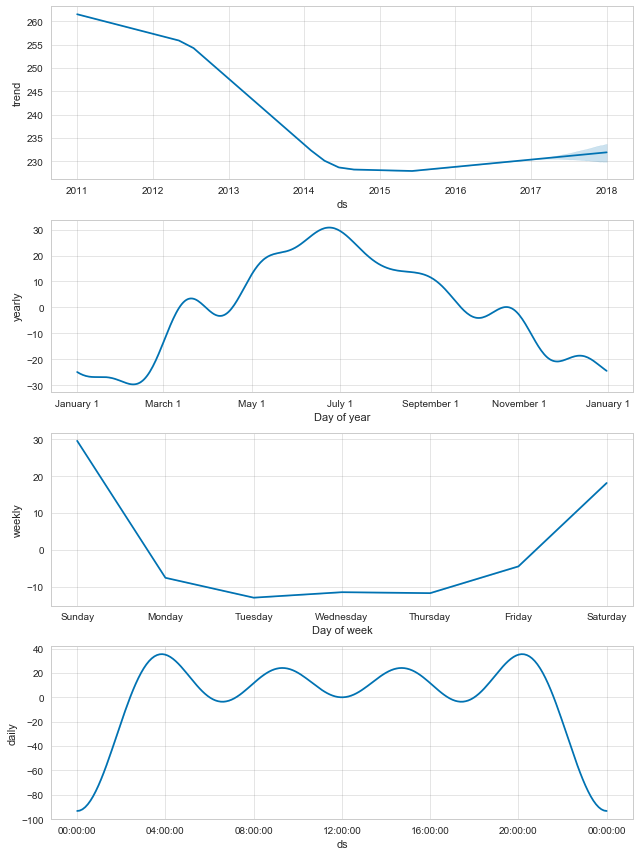

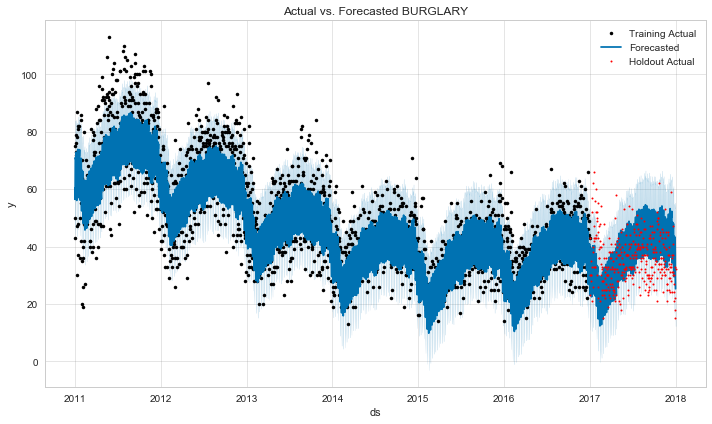

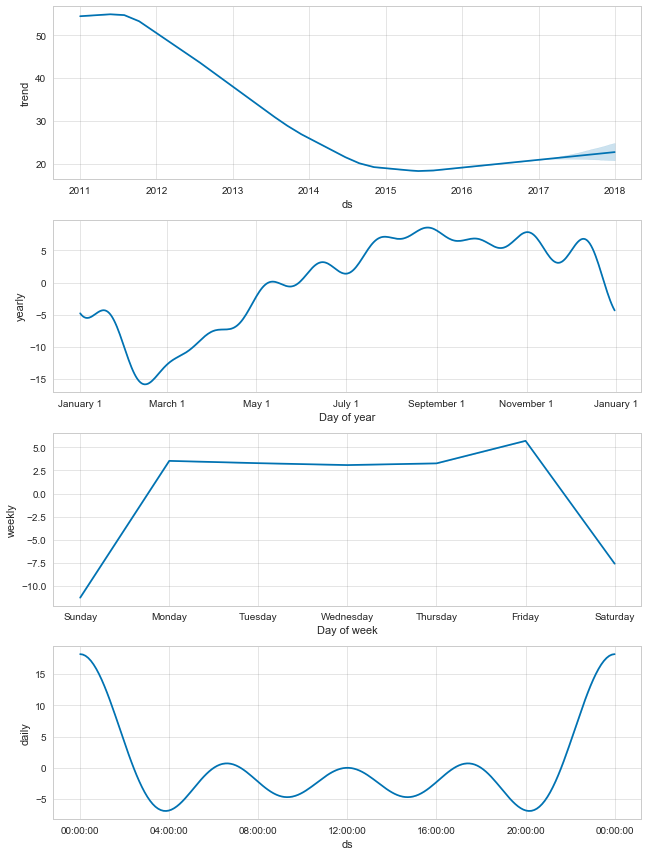

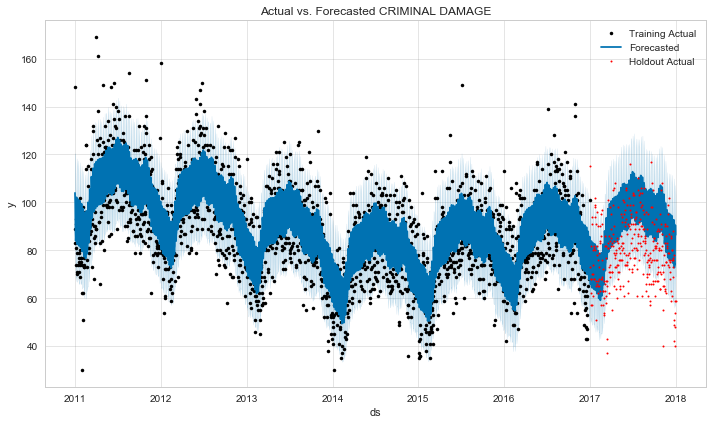

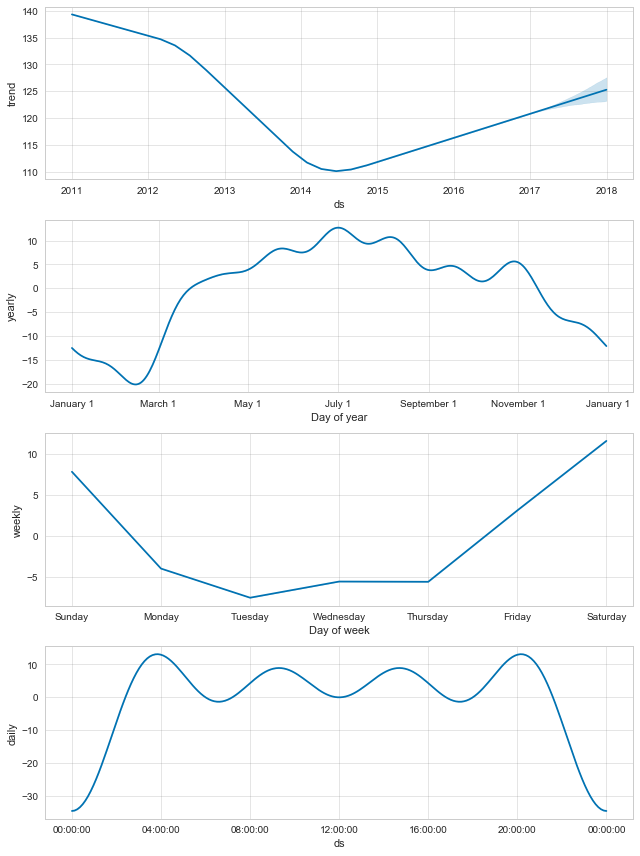

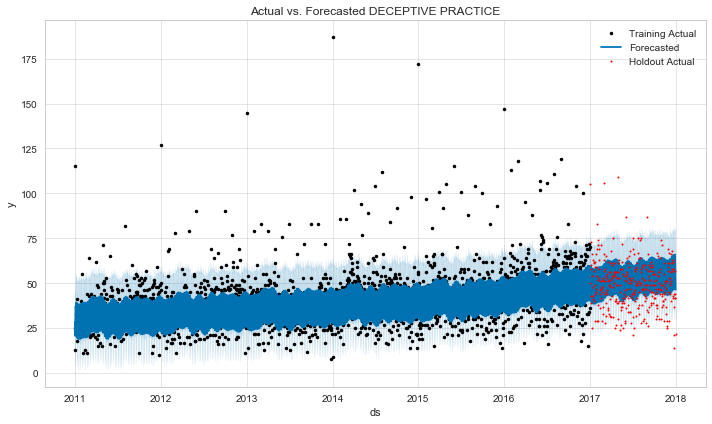

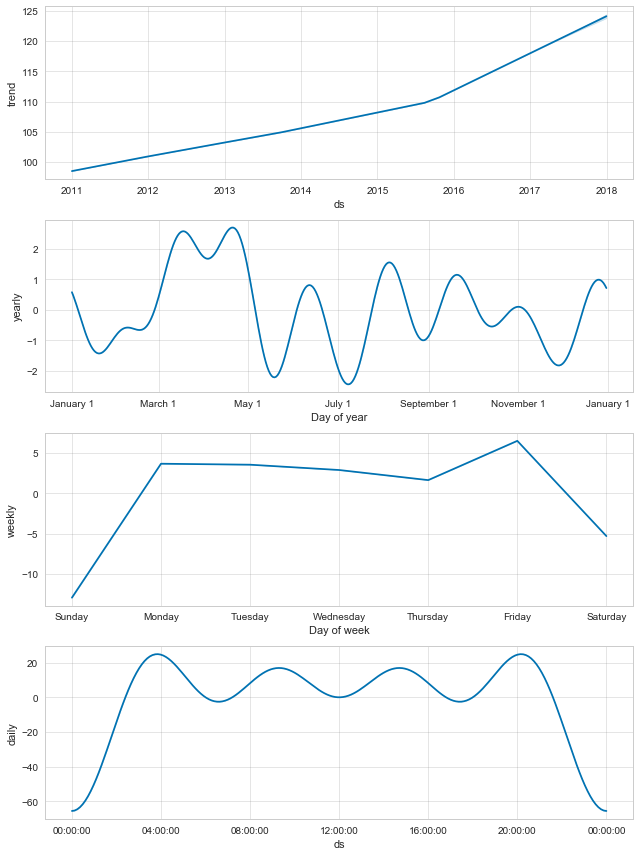

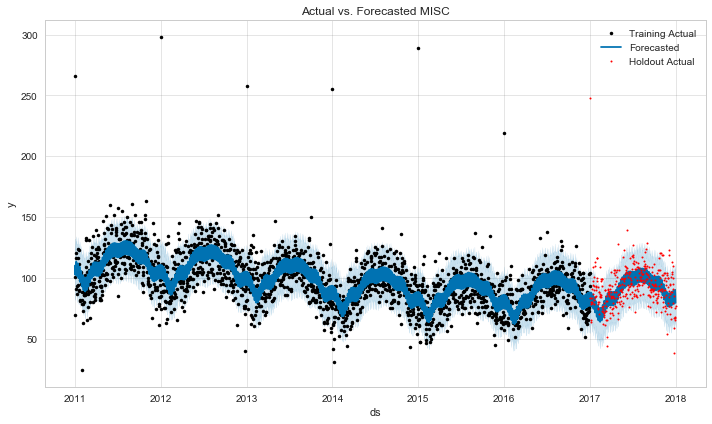

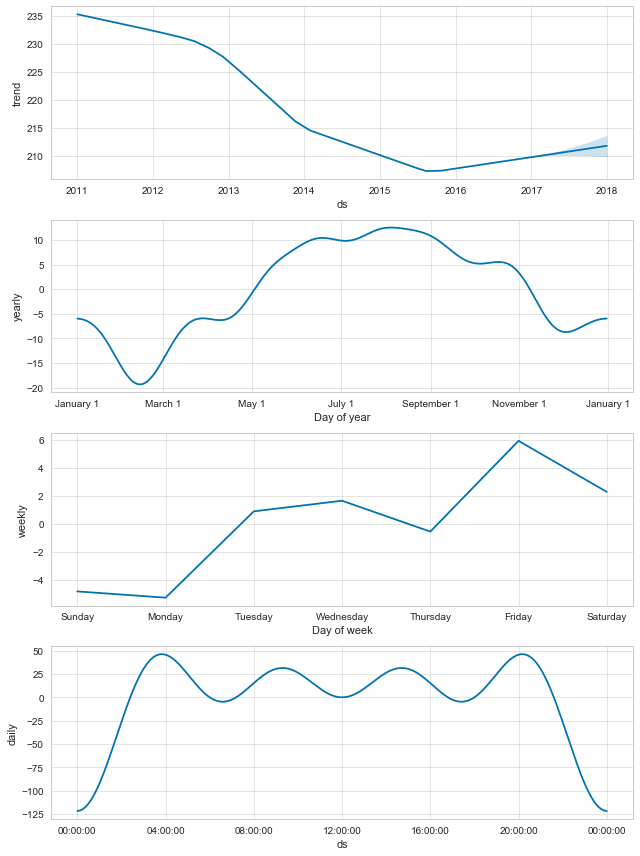

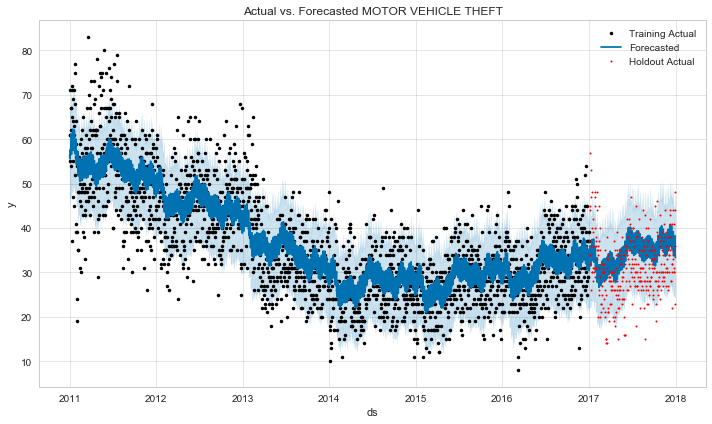

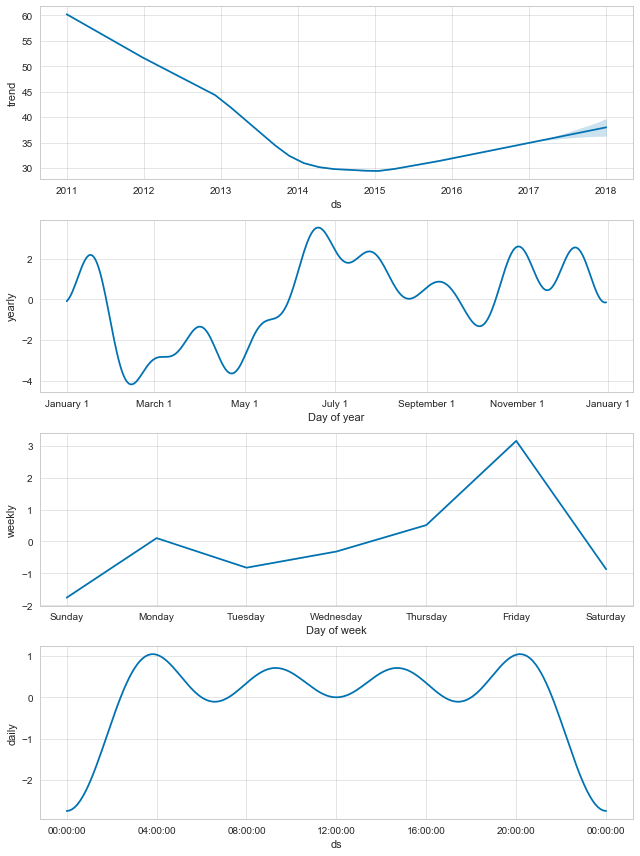

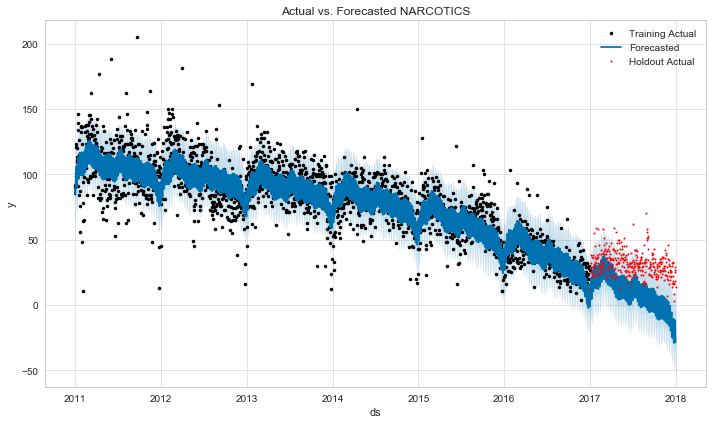

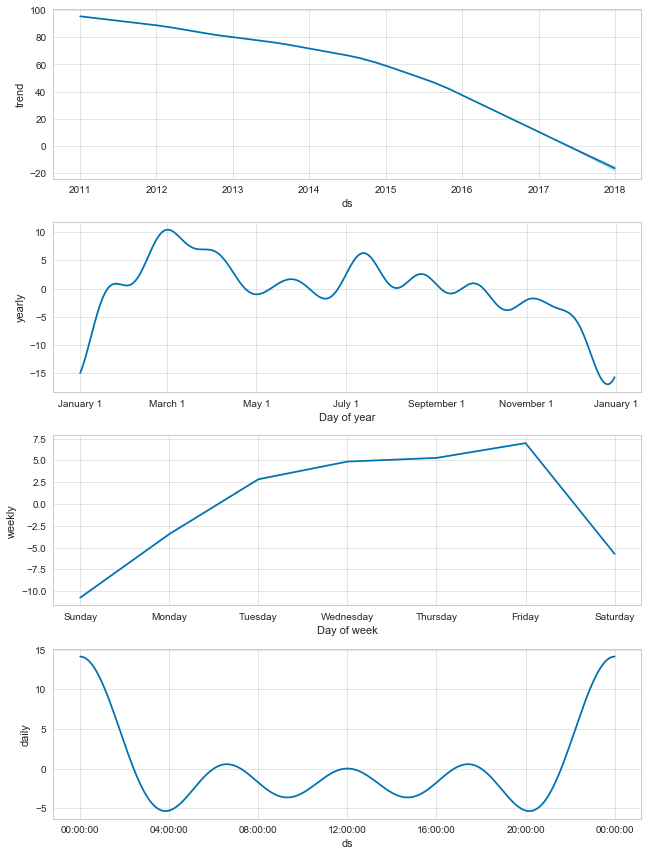

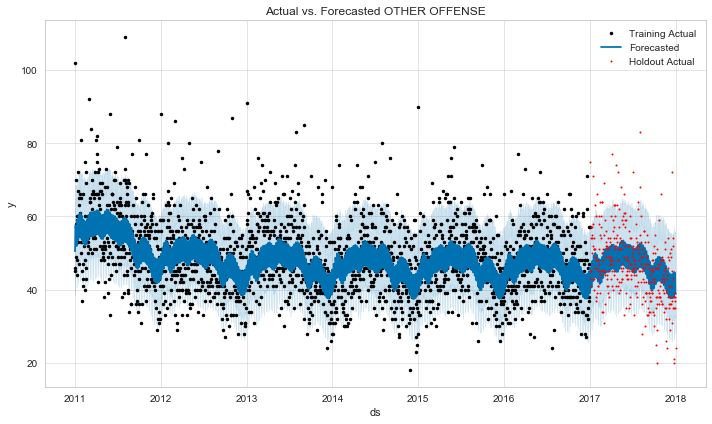

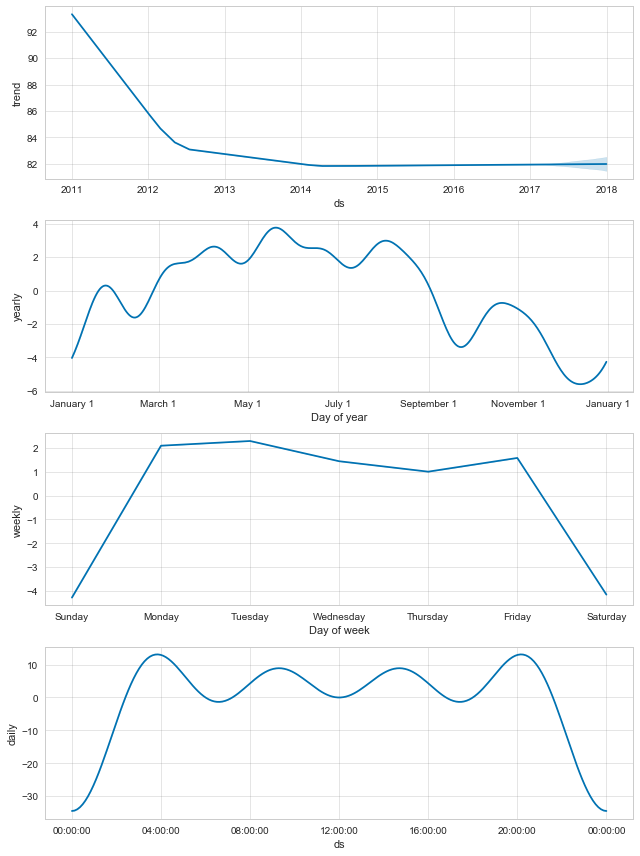

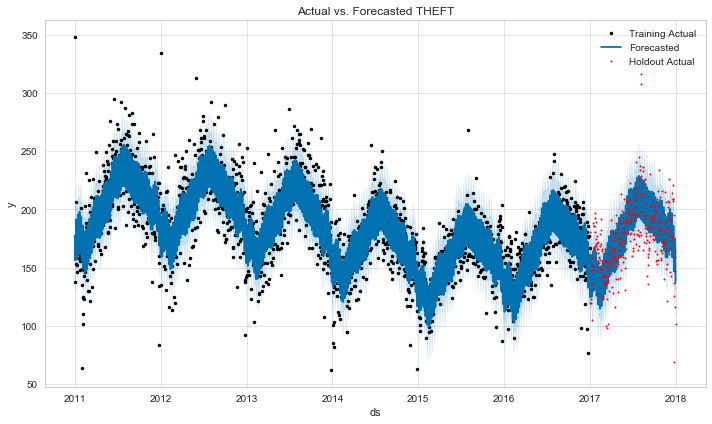

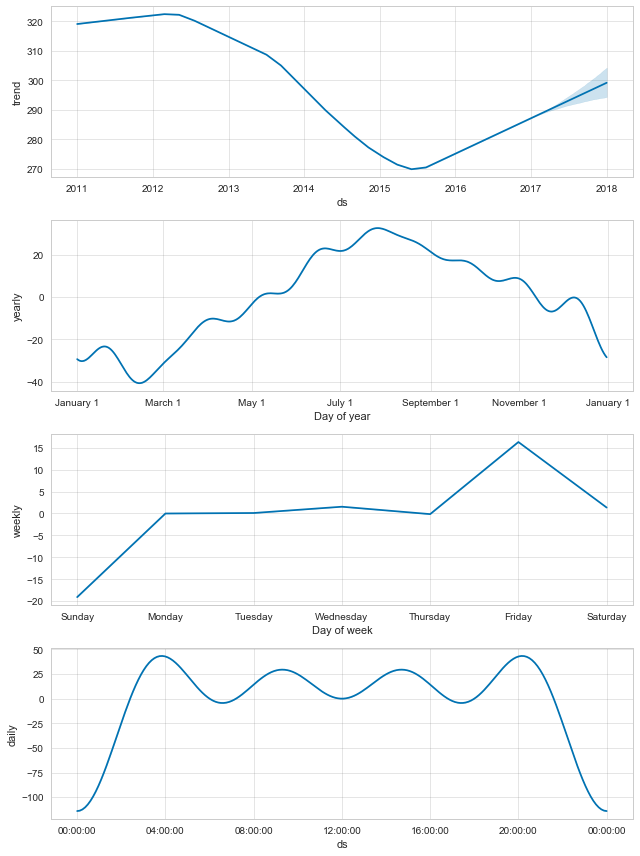

In [158]:
crimes_df_pivot_unstacked = crimes_df_pivot.reset_index()
colnums = crimes_df_pivot_unstacked.shape[1]
rmsedict = {}
for i in range(1,colnums):
    rmsedict[crimes_df_pivot_unstacked.columns[i]] = pred_using_prophet(crimes_df_pivot_unstacked,i)
    #print(rmse)
rmsedf = pd.DataFrame.from_dict(rmsedict,orient='index').rename(columns={0:'RMSE',1:'RMSE_Week'})
rmsedf

#### Using Neural Networks

In [159]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

/Users/amit.dingare/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [160]:
crimes_df['hour'] = crimes_df['time'].apply(lambda x: int(str(x).split(':')[0]))

In [161]:
crimes_df.corr()

,arrest,beat,community_area,district,domestic,id,latitude,longitude,ward,x_coordinate,y_coordinate,year,dow,week,weekend,hour
arrest,1.000000,-0.023142,0.019165,-0.021889,-0.060015,-0.068394,-0.013308,-0.023587,-0.011575,-0.022535,-0.013479,-0.065453,-0.004100,-0.029173,-0.008277,0.083655
beat,-0.023142,1.000000,-0.495880,0.985232,-0.048382,-0.018177,0.458665,-0.353793,0.672175,-0.346014,0.459724,-0.022533,0.015839,-0.000117,0.017420,-0.010456
community_area,0.019165,-0.495880,1.000000,-0.494728,0.077336,-0.023756,-0.549900,0.167411,-0.541735,0.168197,-0.552292,-0.020146,-0.017480,-0.007152,-0.017389,0.005122
district,-0.021889,0.985232,-0.494728,1.000000,-0.047526,-0.001205,0.460547,-0.365821,0.685720,-0.357613,0.461568,-0.004897,0.016217,0.001415,0.017866,-0.010551
domestic,-0.060015,-0.048382,0.077336,-0.047526,1.000000,0.020030,-0.055684,0.007130,-0.066300,0.007699,-0.055977,0.020100,0.031365,-0.008440,0.044385,-0.037930
id,-0.068394,-0.018177,-0.023756,-0.001205,0.020030,1.000000,0.023887,-0.000810,0.015593,-0.001031,0.024008,0.906376,0.001788,0.102791,0.001355,0.000836
latitude,-0.013308,0.458665,-0.549900,0.460547,-0.055684,0.023887,1.000000,0.272584,0.469540,0.288198,0.999991,0.012447,0.011112,-0.006361,0.012430,-0.005266
longitude,-0.023587,-0.353793,0.167411,-0.365821,0.007130,-0.000810,0.272584,1.000000,-0.296487,0.999609,0.271091,0.002502,-0.000783,0.001037,-0.000693,0.003705
ward,-0.011575,0.672175,-0.541735,0.685720,-0.066300,0.015593,0.469540,-0.296487,1.000000,-0.291112,0.470911,0.012484,0.014781,0.004959,0.015305,-0.004321
x_coordinate,-0.022535,-0.346014,0.168197,-0.357613,0.007699,-0.001031,0.288198,0.999609,-0.291112,1.000000,0.286624,0.002479,-0.000852,0.000908,-0.000734,0.003675


In [162]:
crimes_df.to_csv('crimes_df.csv',index=False)

In [163]:
crimes_df = pd.read_csv('crimes_df.csv')

/Users/amit.dingare/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [165]:
crimes_df_sum = crimes_df.groupby(['crime_cat','year','beat','hour','dow','week']).count()['case_number'].to_frame().reset_index()
crimes_df_sum.rename(columns={'case_number':'counts'},inplace=True)

In [192]:
crimes_df_sum[crimes_df_sum['counts']>5].head()

,crime_cat,year,beat,hour,dow,week,counts
535012,BURGLARY,2012,1224,2,0,16,6
586243,BURGLARY,2015,1634,0,2,3,6
607927,BURGLARY,2017,812,1,2,14,6
618266,CRIMINAL DAMAGE,2011,223,1,6,44,14
632344,CRIMINAL DAMAGE,2011,913,5,6,17,10


#### Plotting

/Users/amit.dingare/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


(10,)


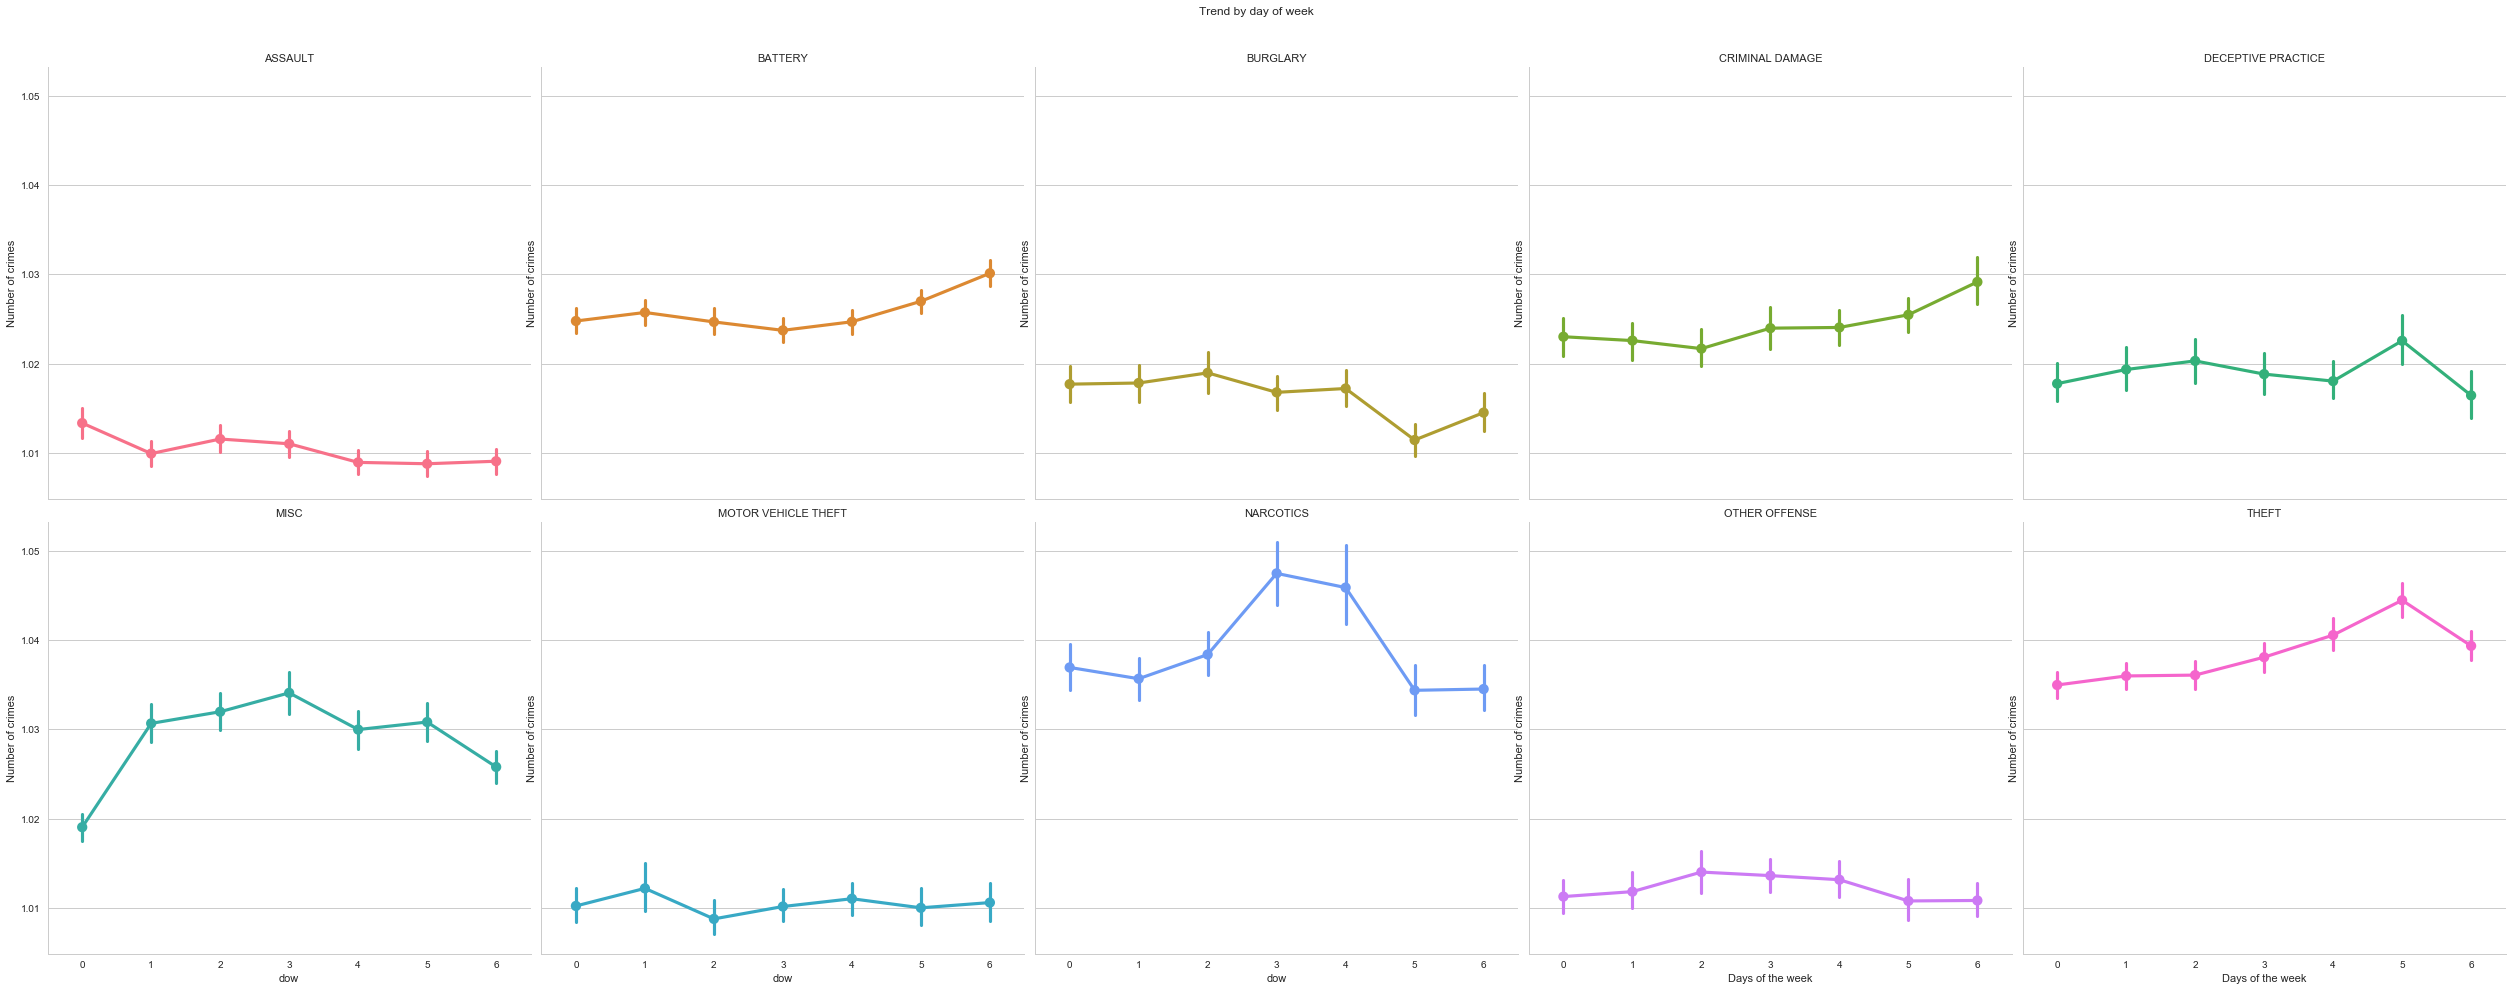

In [179]:
# Create a grid : initialize it
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
g = sns.FacetGrid(crimes_df_sum, col='crime_cat', hue='crime_cat', col_wrap=5, size=7)
 

# Fill the area with fill_between
g = g.map(sns.pointplot, 'dow', 'counts').set_titles("{col_name} crime_cat")
 
# Control the title of each facet
g = g.set_titles("{col_name}")

print (g.axes.shape)
# add axis labels
for i in range(g.axes.shape[0]):
    #g.axes[i,].set_xlabel('Days of the week')
    g.axes[i,].set_ylabel('Number of crimes')
for j in range(8,10):
    g.axes[j,].set_xlabel('Days of the week')
    #g.set_xticklabels(np.arrange(7),days)

    
# for ax in g.axes.flat:
#     ax.set_xticklabels(np.arange(7), days)
#     for label in ax.get_xticklabels():
#         label.set_rotation(90)

g.savefig('Plotbydayofweek.png')
    # Add a title for the whole plo
plt.subplots_adjust(top=0.92)

g = g.fig.suptitle('Trend by day of week')


plt.show()


/Users/amit.dingare/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


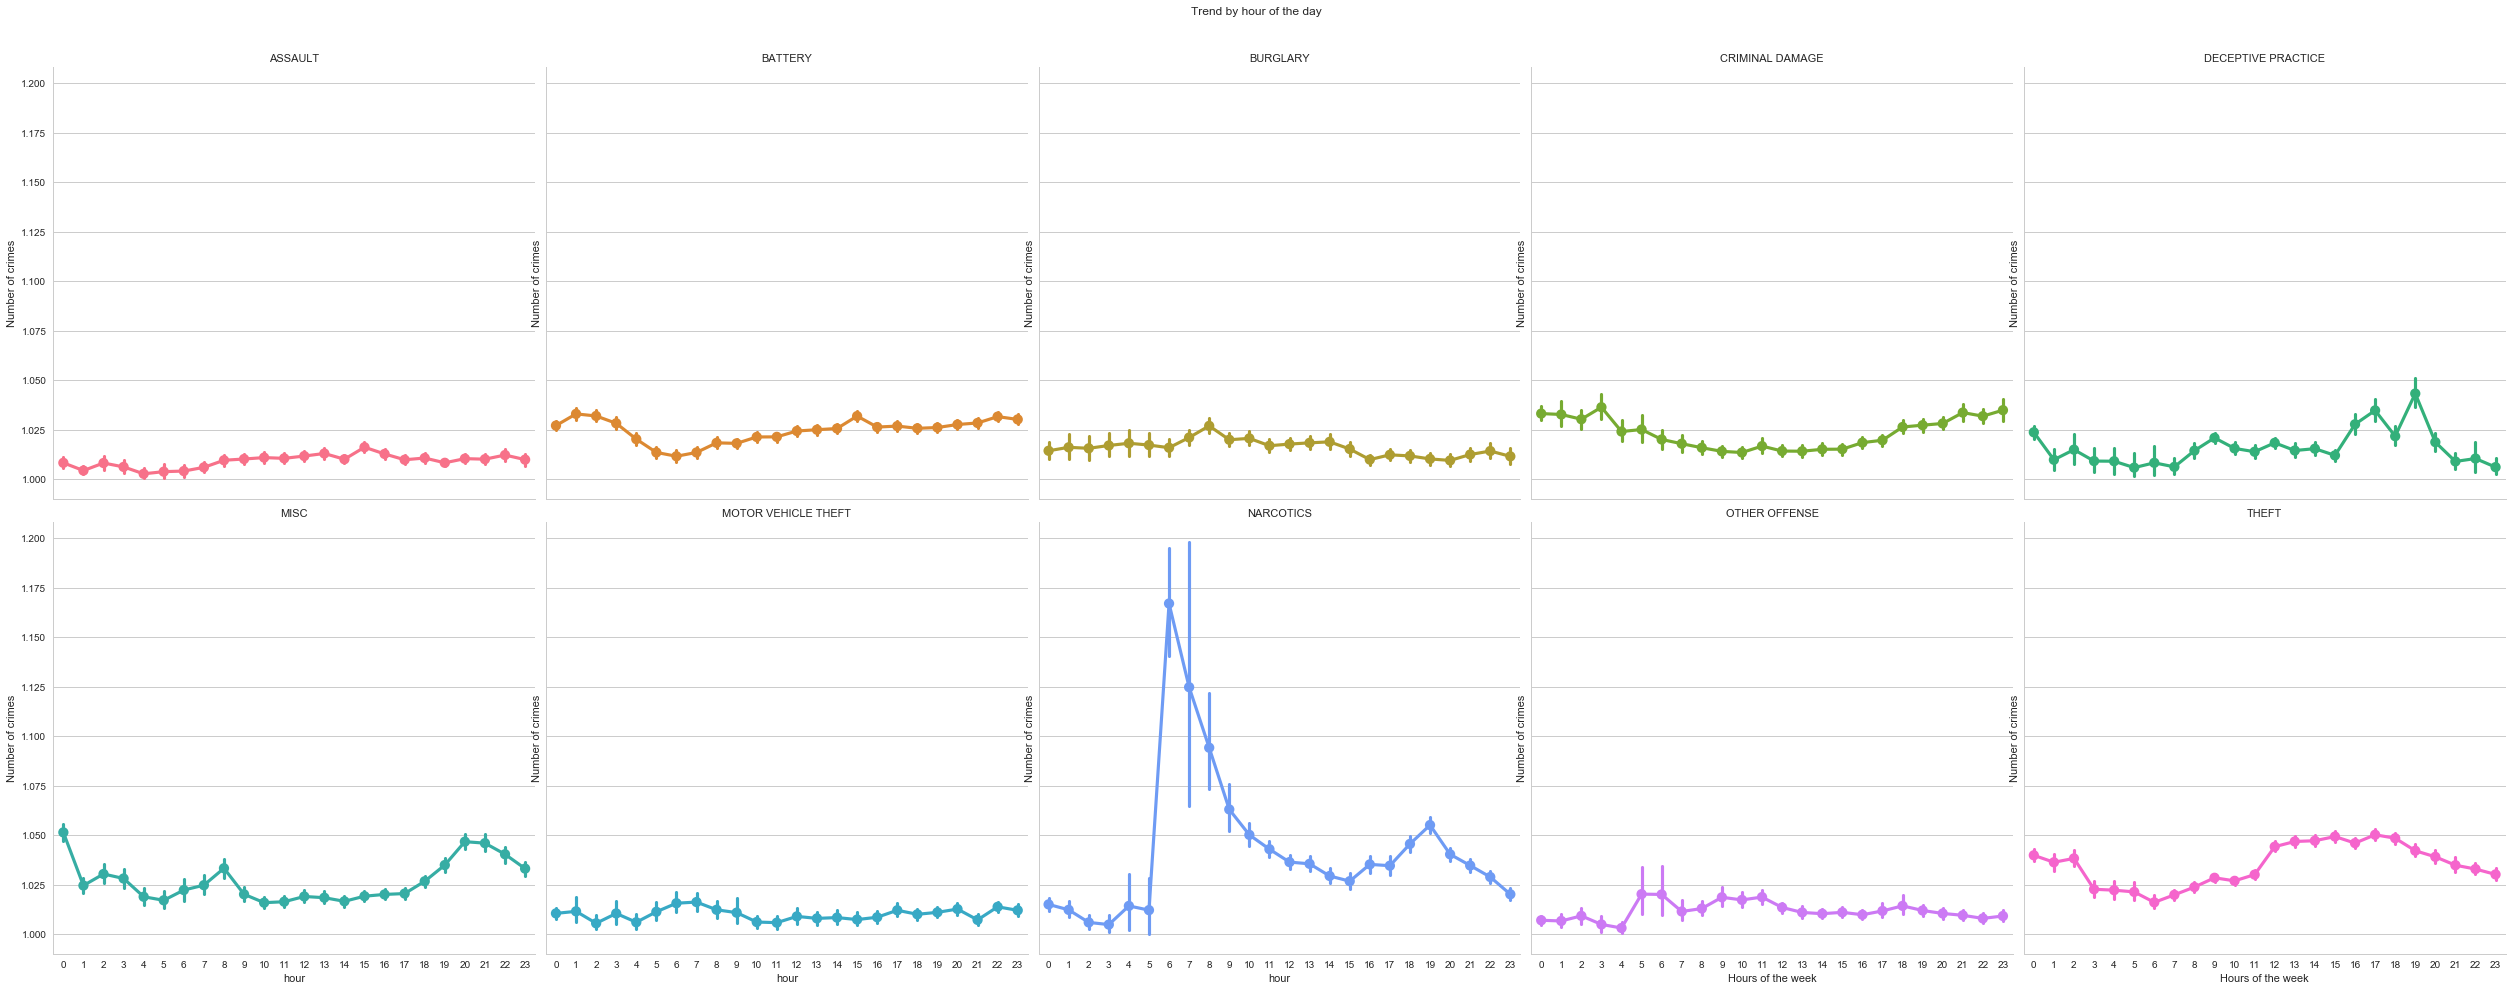

In [180]:
# Create a grid : initialize it
hours = range(0,24)
g = sns.FacetGrid(crimes_df_sum, col='crime_cat', hue='crime_cat', col_wrap=5, size=7)
 

# Fill the area with fill_between
g = g.map(sns.pointplot, 'hour', 'counts').set_titles("{col_name} crime_cat")
 
# Control the title of each facet
g = g.set_titles("{col_name}")

#print (g.axes.shape)
# add axis labels
for i in range(g.axes.shape[0]):
    #g.axes[i,].set_xlabel('Days of the week')
    g.axes[i,].set_ylabel('Number of crimes')
for j in range(8,10):
    g.axes[j,].set_xlabel('Hours of the week')

    
# for ax in g.axes.flat:
#     ax.set_xticklabels(np.arange(7), days)
#     for label in ax.get_xticklabels():
#         label.set_rotation(90)

g.savefig('Plotbyhourofday.png')
    # Add a title for the whole plo
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('Trend by hour of the day')

 
plt.show()


/Users/amit.dingare/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


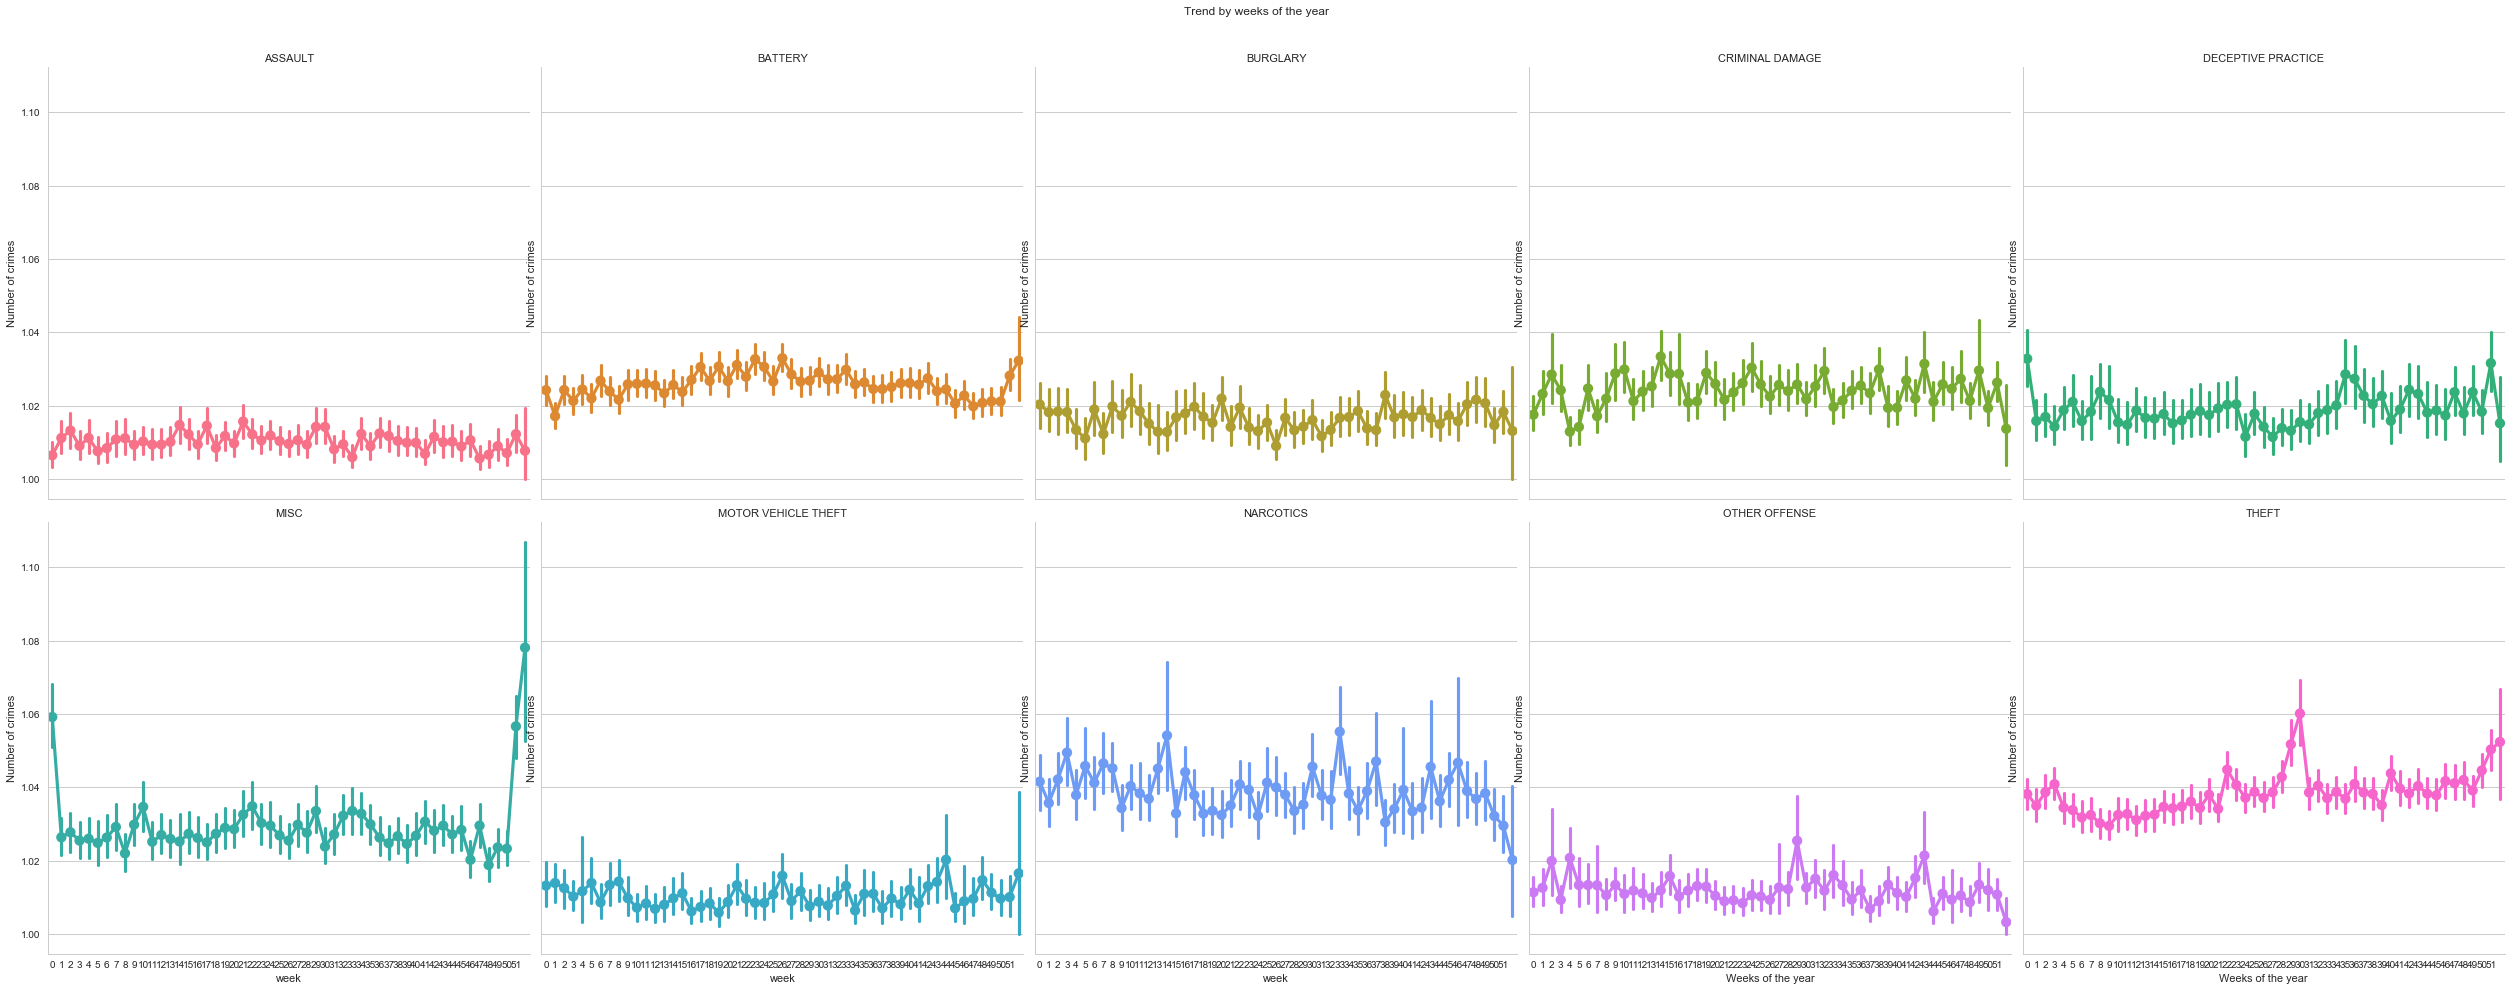

In [181]:
# Create a grid : initialize it
weeks = range(0,52)
g = sns.FacetGrid(crimes_df_sum, col='crime_cat', hue='crime_cat', col_wrap=5, size=7)
 

# Fill the area with fill_between
g = g.map(sns.pointplot, 'week', 'counts').set_titles("{col_name} crime_cat")
 
# Control the title of each facet
g = g.set_titles("{col_name}")

#print (g.axes.shape)
# add axis labels
for i in range(g.axes.shape[0]):
    #g.axes[i,].set_xlabel('Days of the week')
    g.axes[i,].set_ylabel('Number of crimes')
for j in range(8,10):
    g.axes[j,].set_xlabel('Weeks of the year')

g.set_xticklabels(np.arange(52),weeks)   
# for ax in g.axes.flat:
#     ax.set_xticklabels(np.arange(7), days)
#     for label in ax.get_xticklabels():
#         label.set_rotation(90)

g.savefig('Plotbyweek.png')
    # Add a title for the whole plo
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('Trend by weeks of the year')

 
plt.show()


In [182]:
# fix random seed for reproducibility
seed = 7

In [183]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [184]:
# evaluate model with standardized dataset
# estimators = []
# estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5000,
#     verbose=0)))
# pipeline = Pipeline(estimators)
# kfold = KFold(n_splits=10, random_state=seed)
# results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
# print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [185]:
# scale = StandardScaler()
# X_train = scale.fit_transform(X_train)

# #This is the change
# X_test = scale.transform(X_test)

# model_np = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5000,
#     verbose=0)
# log = model_np.fit(X_train, y_train)
# y_pred = model_np.predict(X_test)

In [186]:
def split_df_by_year(df):
    train = df.loc[df['year']< 2017,:]
    test = df.loc[(df['year']>= 2017) 
                                     & (df['year']< 2018),:]
    return (train, test)

In [187]:
# assault_df_sum = crimes_df_sum[crimes_df_sum['crime_cat']=='ASSAULT']
# (train, test) = split_df_by_year(assault_df_sum)
# train_dataset = train.values
# test_dataset = test.values
# X_train = train_dataset[:,2:6]
# y_train = train_dataset[:,6]
# X_test = test_dataset[:,2:6]
# y_test = test_dataset[:,6]

In [188]:
def get_mlp_rmse(val):
    #print (val)
    val_df_sum = crimes_df_sum[crimes_df_sum['crime_cat']==val]
    (train, test) = split_df_by_year(val_df_sum)
    train_dataset = train.values
    test_dataset = test.values
    # split into input (X) and output (Y) variables
    X_train = train_dataset[:,2:6]
    y_train = train_dataset[:,6]
    X_test = test_dataset[:,2:6]
    y_test = test_dataset[:,6]
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)
    
    scale = StandardScaler()
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)

    model_np = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5000,
    verbose=0)
    log = model_np.fit(X_train, y_train)
    y_pred = model_np.predict(X_test)
    test['y_pred'] = y_pred
    test_sum = test.groupby(['week']).agg({'counts':['sum'],'y_pred':['sum']}).reset_index(col_level=1)
    #print (test_sum.head())
    #test_sum.columns = test_sum.columns.get_level_values(1)
    test_sum.columns = ['week','ActualTotals','PredTotals']
    #test_sum.rename(columns={'level_0':'actual_counts','level_1':'predicted_counts'},inplace=True)
    #print (test_sum.head())
    #print (test_sum.columns)
    rmse_weekly = sqrt(mean_squared_error(test_sum.ActualTotals,test_sum.PredTotals))
    rmse = sqrt(mean_squared_error(y_test,np.round(y_pred,0)))
    return (rmse,rmse_weekly)

In [189]:
# fix random seed for reproducibility
seed = 7
rmsedict = {}
for cat in uniquecrimecat:
    rmsedict[cat] = get_mlp_rmse(cat)
rmsedf = pd.DataFrame.from_dict(rmsedict,orient='index').rename(columns={0:'RMSE',1:'RMSE_Week'})
rmsedf

/Users/amit.dingare/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/amit.dingare/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,RMSE,RMSE_Week
BATTERY,0.160268,5.577753
THEFT,0.282039,30.562912
NARCOTICS,0.259559,4.452092
ASSAULT,0.100309,2.378946
MISC,0.183790,8.048224
DECEPTIVE PRACTICE,0.131703,2.609011
OTHER OFFENSE,0.112722,2.542436
CRIMINAL DAMAGE,0.211461,4.339582
BURGLARY,0.132168,2.170177
MOTOR VEHICLE THEFT,0.107537,1.657921
